<center>
    <h1>Anonymizing Trajectory for Data Publishing</h1>
    <br /><br />
    <a href="mailto:Ndeye-fatou.niang@ens.uvsq.fr">Ndeye Fatou Niang</a>
    <br />
    <a href="mailto:Rosemonde-benedicte.traore@ens.uvsq.fr">Rosemonde Benedicte Traore</a>
    <br />
    <a href="mailto:aissa.toumi@ens.uvsq.fr">Aïssa Toumi</a>
    <br />
    Université de Versailles Saint-Quentin en Yvelines
</center>

# Librairies

In [1]:
import os
import pandas as pd
import glob
from pathlib import Path
from skmob.core.trajectorydataframe import TrajDataFrame
from skmob.privacy import attacks
from skmob.preprocessing import filtering, compression, detection, clustering
from skmob.measures.individual import home_location
import folium
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt 

# Importation des données

Récupération des fichiers csv inclut dans le fichier ( chemin du path). Ajout d'une colonne avec identifiant correspondant au nom du fichier csv.

In [2]:
path = r'C:\Users\aissa\Documents\M2 DATASCALES\Projet\Untitled Folder\GPSall' # Mettre le path du fichier qui comprend toutes les tablettes différentes
final = []
for file_name in os.listdir(path):
    current_path = "".join((path, "/", file_name))
    all_files = glob.glob(current_path+ "/*.csv") #Récupère tous les fichiers .csv
    li = []

    for filename in all_files:
        try:
            df = pd.read_csv(filename, index_col=None, header=0)
            df["uid"] = Path(filename).stem #récupère le nom du fichier.
            li.append(df)
        except:
            pass
        frame_tmp = pd.concat(li, axis=0, ignore_index=True) # Dataframe de chaque dossier
        final.append(frame_tmp)
    
frame = pd.concat(final, axis=0, ignore_index=True) # Dataframe avec concaténation de tous les dossiers

In [3]:
print(len(frame['uid'].unique())) # Nombre d'identifiant différents

259


In [4]:
trjs = frame[['time','lat','lon','uid']] # Récupère les colonnes time, latitude, longitude et id utilisateur

Du fait que les données sont conséquentes, et pour réaliser le pré-traitement des données dans un temps raisonnable on restreint l'intervalle de temps. 

In [5]:
trjs_1semaine = trjs[trjs['time'].between('2019-10-21', '2019-10-27')] #Choix de l'intervalle de temps
print(len(trjs_1semaine['uid'].unique()))

26


# Transformation TrajDataframe

Le TrajDataFrame est un DataFrame utilisé comme structure de base à scikit-mobility

In [6]:
trjs_1semaine =TrajDataFrame(trjs_1semaine, latitude='lat',longitude ='lon',datetime='time', user_id='uid')
trjs_1semaine

,datetime,lat,lng,uid
2641652,2019-10-23 12:13:07.428000+00:00,48.849677,2.383838,CH184703947_20191023
2641653,2019-10-23 12:13:07.428000+00:00,48.849677,2.383838,CH184703947_20191023
2641654,2019-10-23 12:13:07.428000+00:00,48.849677,2.383838,CH184703947_20191023
2641655,2019-10-23 12:13:07.428000+00:00,48.849677,2.383838,CH184703947_20191023
2641656,2019-10-23 12:13:28.191000+00:00,48.851032,2.384779,CH184703947_20191023
...,...,...,...,...
12880850,2019-10-26 23:56:56.258000+00:00,48.818318,2.150708,CH184703945_20191027
12880851,2019-10-26 23:56:56.258000+00:00,48.818318,2.150708,CH184703945_20191027
12880852,2019-10-26 23:58:22.201000+00:00,48.818318,2.150708,CH184703945_20191027
12880853,2019-10-26 23:58:54.080000+00:00,48.818318,2.150708,CH184703945_20191027


Affichage des trajectoires sur une map Folium, on peut régler le nombre maximum d'utilisateurs que l'on souhaite afficher sur le graphique avec le paramètre "max_users". 

In [7]:
trjs_1semaine.plot_trajectory(max_users = 260)

# Preprocesssing

Afin de réduire les bruits et différentes erreur de localisation on doit réaliser un preprocessing sur nos données. 

## Filtering

La fonction filtering.filter permet de filitrer les trajectoires considérer comme étant du bruit ou des anomalies. On peut ansi régler la vitesse maximal entre deux points successif.

In [8]:
# Permet de filtrer toutes les trajectoires où la vitesse est supérieure a 100 km/h
ftrjs_1semaine = filtering.filter(trjs_1semaine, max_speed_kmh=100.)
ftrjs_1semaine.plot_trajectory(max_users = 260)

## Compression

Réduit le nombre de points inclus dans un rayon prédéfini.

In [9]:
ctrjs_1semaine = compression.compress(ftrjs_1semaine, spatial_radius_km=0.2) # rayon de 200 m 
ctrjs_1semaine.plot_trajectory(max_users = 260)

# Détection d'arrêt

Détecte les arrêts pour chaque individu. Un arrêt est détecté lorsque l'individu passe au moins un nombre de minutes entrée en paramètre à une distance défini en paramètre. Pour calculer la distance on fait stop_radius_factor * spatial_radius_km. leaving_time ajoute une colonne leaving_datetime avec l'heure de départ du point d'arrêt. 

In [10]:
# Dans notre exemple, un arrêt est détecté lorsque l'individu passe au moins 10 minutes à une distance de 0.8*O.5 = 0.4 km 
strjs_1semaine = detection.stops(ctrjs_1semaine, stop_radius_factor=0.8,minutes_for_a_stop=10.0, spatial_radius_km=0.2,leaving_time=True)

In [48]:
strjs_1semaine_bis = detection.stops(ftrjs_1semaine, stop_radius_factor=0.8,minutes_for_a_stop=10.0, spatial_radius_km=0.2,leaving_time=True)

In [49]:
strjs_1semaine_bis[strjs_1semaine_bis["uid"]=="CH184703914_20191021"]

,datetime,lat,lng,uid,leaving_datetime
0,2019-10-21 00:00:19+00:00,48.815440,2.045643,CH184703914_20191021,2019-10-21 06:45:13+00:00
1,2019-10-21 07:45:05+00:00,48.832186,2.258780,CH184703914_20191021,2019-10-21 11:07:32+00:00
2,2019-10-21 11:15:17+00:00,48.833017,2.232912,CH184703914_20191021,2019-10-21 11:28:33+00:00
3,2019-10-21 11:38:52+00:00,48.832842,2.260165,CH184703914_20191021,2019-10-21 17:17:01+00:00


In [50]:
strjs_1semaine_bis.plot_stops()

In [51]:
len(strjs_1semaine_bis)

180

Les différents arrêts détectés pour un individu particulier (ex : CH184703914_20191021)

In [11]:
strjs_1semaine[strjs_1semaine["uid"]=="CH184703914_20191021"]

,datetime,lat,lng,uid,leaving_datetime
0,2019-10-21 00:00:19+00:00,48.815440,2.045643,CH184703914_20191021,2019-10-21 06:45:13+00:00
1,2019-10-21 07:45:05+00:00,48.831774,2.258077,CH184703914_20191021,2019-10-21 11:08:03+00:00
2,2019-10-21 11:14:15+00:00,48.832389,2.233713,CH184703914_20191021,2019-10-21 11:28:33+00:00
3,2019-10-21 11:38:52+00:00,48.832842,2.260165,CH184703914_20191021,2019-10-21 17:17:01+00:00


In [12]:
strjs_1semaine.plot_stops() # Affichage de tous les arrêts détectés pour les différents individus

In [52]:
len(strjs_1semaine)

175

# Home location

La fonction home_location récupère le lieu le plus visité par un individu, entre 22h et 7h. 

In [13]:
home_location_1semaine = home_location(ctrjs_1semaine)
home_location_1semaine

100%|██████████| 26/26 [00:00<00:00, 206.33it/s]


,uid,lat,lng
0,CH184703914_20191021,48.799415,2.069928
1,CH184703914_20191022,48.815365,2.045690
2,CH184703914_20191023,48.798195,2.147807
3,CH184703914_20191024,48.798272,2.146867
4,CH184703914_20191025,48.815380,2.045680
5,CH184703914_20191026,48.815393,2.045687
6,CH184703917_20191021,48.782739,2.119875
7,CH184703917_20191022,48.782888,2.119022
8,CH184703917_20191023,48.782791,2.119882
9,CH184703917_20191024,48.782810,2.119786


home_location_map est une fonction qui permet d'afficher les coordonnées et les afficher sur une carte. 

In [14]:
def home_location_map(home_location):
    lat_map = home_location['lat'].median() # Récupère la valeur médiane de latitude et longitude afin de centrer la carte
    lon_map = home_location['lng'].median()
    taille,_=home_location.shape
    m = folium.Map(location=[lat_map, lon_map]) # On centre la carte sur les valeurs médianes
    tooltip = "Home"

    for i in range(taille):
        " Ajoute un markeur sur la carte pour chacune des coordonnées"
        folium.Marker([home_location['lat'][i], home_location['lng'][i]], popup=home_location['uid'][i], tooltip=tooltip).add_to(m)

    return(m)

home_location_map(home_location_1semaine)

## Work location

La fonction work_location permet de récupérer les coordonnées du lieu de travail d'un individu. La fonction est basée sur la fonction home_location précédente en décalant les horaires. On a fixé l'intervalle de temps de 7h à 18h en supposant que les individus travaillent la journée ( dans le cas contraire ces coordonnées de domicile et de lieu de travail sont échangées)

In [15]:
#work_location permet de récupérer le lieu le plus visité de 7h à 18h
def work_location(trajs):
    work_location = home_location(ctrjs_1semaine, "7:00", "18:00")
    return(work_location)
work_location_1semaine = work_location(ctrjs_1semaine)
work_location_1semaine

100%|██████████| 26/26 [00:00<00:00, 206.34it/s]


,uid,lat,lng
0,CH184703914_20191021,48.798220,2.146035
1,CH184703914_20191022,48.798210,2.146298
2,CH184703914_20191023,48.823745,2.211023
3,CH184703914_20191024,48.798272,2.146867
4,CH184703914_20191025,48.798163,2.146762
5,CH184703914_20191026,48.799426,2.126178
6,CH184703917_20191021,48.783105,2.120620
7,CH184703917_20191022,48.784419,2.102093
8,CH184703917_20191023,48.782743,2.120252
9,CH184703917_20191024,48.782703,2.120179


La fonction home_work_location_map permet d'afficher sur une carte de la même couleur avec des symboles différents le lieu de domicile et le lieu de travail.

In [16]:
import folium
def home_work_location_map(home_location,work_location):             
    lat_map = home_location['lat'].median()
    lon_map = home_location['lng'].median()
    taille,_=home_location.shape
    m = folium.Map(location=[lat_map, lon_map])
    tooltip_home = "Home"
    tooltip_work = "Work"
    
    color_icon = ["red", "blue", "green", "purple", "orange", "darkred","lightred", "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", "pink", "lightblue", "lightgreen", "gray", "black", "lightgray"]
    for i in range(taille):
        folium.Marker([work_location['lat'][i], work_location['lng'][i]], popup=work_location['uid'][i], tooltip=tooltip_work, icon=folium.Icon(color=color_icon[i % len(color_icon)], icon="briefcase")).add_to(m)
        folium.Marker([home_location['lat'][i], home_location['lng'][i]], popup=home_location['uid'][i], tooltip=tooltip_home, icon=folium.Icon(color=color_icon[i % len(color_icon)], icon="home")).add_to(m)
    return(m)

home_work_location_map(home_location_1semaine, work_location_1semaine)

### Décomposition de la fonction home_location

La fonction home_location récupère toutes les coordonnées enregistrées entre 22:00 et 07:00, fait un groupBy sur latitude et longitude. Récupère ainsi la position qui se répète le plus la nuit. Elle n'a cependant aucun intérêt lorsque aucun point ne se répète. En effet, la fonction dans ce cas récupère la première position. De plus, s'il n'y a aucun point dans les horaires sélectionnés il récupère le lieu le plus visité dans toutes les coordonnées récupérées (y compris ceux qui ne sont pas compris dans l'intervalle de temps . 

In [17]:
night_visits = ctrjs_1semaine.set_index(pd.DatetimeIndex(ctrjs_1semaine.datetime)).between_time('22:00', '07:00')
night_visits[night_visits['uid'] == 'CH184703914_20191021'].groupby(['lat', 'lng']).count()

,,datetime,uid
lat,lng,,
48.799415,2.069928,1,1
48.799676,2.067920,1,1
48.800257,2.073130,1,1
48.800602,2.076022,1,1
48.800825,2.078937,1,1
48.801012,2.062993,1,1
48.801180,2.082203,1,1
48.801502,2.085482,1,1
48.801788,2.088417,1,1


In [18]:
night_visits[night_visits['uid'] == 'CH184703914_20191021'].groupby(['lat', 'lng']).count().sort_values(by='datetime', ascending=False).iloc[0].name

(48.799414999999996, 2.0699283333333334)

### Modification de la fonction home_location

On a choisi de modifié la fonction home_laction, on fait en sorte qu'on a au minmum un nombre de points entrées en paramètre au même endroit dans le laps de temps choisi. Dans le cas contraire il ne renvoie pas de coordonnées. 

In [19]:
def home_location_individual_custom(traj, start_night='22:00', end_night='07:00', nombre_de_points = 2):
    night_visits = traj.set_index(pd.DatetimeIndex(traj.datetime)).between_time(start_night, end_night)
    lat = 0
    lng = 0
    if len(night_visits) != 0: # vérifie s'il y a des coordonnées dans l'intervalle de temps sélectionné
        night = night_visits.groupby(['lat', 'lng']).count().sort_values(by='datetime', ascending=False)
        if night['datetime'].iloc[0] >= nombre_de_points: # verifie si les coordonnées se rèpete aux moins "nombre_de_points" fois
            lat, lng = night_visits.groupby(['lat', 'lng']).count().sort_values(by='datetime', ascending=False).iloc[0].name
    home_coords = (lat, lng)
    return home_coords

In [20]:
def home_location_custom(traj, start_night='22:00', end_night='07:00',nombre_de_points= 2, show_progress=True):
    if 'uid' not in traj.columns:
        return pd.DataFrame([home_location_individual_custom(traj, start_night=start_night, end_night=end_night,nombre_de_points=nombre_de_points)], columns=['lat', 'lng'])
    
    if show_progress:
        df = traj.groupby('uid').progress_apply(lambda x: home_location_individual_custom(x, start_night=start_night, end_night=end_night,nombre_de_points=nombre_de_points))
    else:
        df = traj.groupby('uid').apply(lambda x: home_location_individual_custom(x, start_night=start_night, end_night=end_night,nombre_de_points=nombre_de_points))
    return pd.DataFrame(df.to_list(), index=df.index).reset_index().rename(columns={0: 'lat', 1: 'lng'})


In [21]:
home_location_custom_1semaine = home_location_custom(ctrjs_1semaine)
home_location_custom_1semaine.drop( home_location_custom_1semaine[ home_location_custom_1semaine['lat'] == 0 ].index, inplace=True) # Supprime toutes les lignes où la valeur de lat et lng est 0 
home_location_custom_1semaine.reset_index(drop=True,inplace = True) # réintialise l'index du dataFrame
home_location_custom_1semaine

100%|██████████| 26/26 [00:00<00:00, 218.47it/s]


,uid,lat,lng
0,CH184703941_20191024,48.777200,2.061506
1,CH184703941_20191025,48.777200,2.061506
2,CH184703941_20191027,48.777200,2.061506
3,CH184703945_20191024,48.821772,2.150970


### Modification de la fonction work_location

De même que pour la fonction home_location, on modifie la fonction work_location

In [22]:
def work_location_custom(trajs, nombre_de_points = 2):
    work_location_custom = home_location_custom(trajs, "7:00", "18:00", nombre_de_points)
    return(work_location_custom)
work_location_custom_1semaine = work_location_custom(ctrjs_1semaine)
work_location_custom_1semaine
work_location_custom_1semaine.drop( work_location_custom_1semaine[ work_location_custom_1semaine['lat'] == 0 ].index, inplace=True)
work_location_custom_1semaine.reset_index(drop=True, inplace= True)
work_location_custom_1semaine

100%|██████████| 26/26 [00:00<00:00, 183.09it/s]


,uid,lat,lng
0,CH184703941_20191024,48.777200,2.061506
1,CH184703941_20191025,48.774031,2.063016
2,CH184703941_20191026,48.774031,2.063016
3,CH184703945_20191023,48.817363,2.151334
4,CH184703945_20191024,48.808139,2.140159
5,CH184703945_20191025,48.810385,2.154648
6,CH184703945_20191026,48.836466,2.155580


Fonction qui permet de récupérer les identifiants où on a en même temps la localisation de son domicile et de son travaille

In [23]:
def fusion_home_work(home_location,work_location):
    if len(home_location['uid'].unique()) != len(work_location['uid'].unique()):
        for i in home_location['uid'].unique():
            if i not in work_location['uid'].unique():
                home_location.drop( home_location[ home_location['uid'] == i ].index, inplace = True)
        for i in work_location['uid'].unique():
            if i not in home_location['uid'].unique():
                work_location.drop( work_location[ work_location['uid'] == i ].index, inplace = True)
    work_location.reset_index(drop=True, inplace= True)
    home_location.reset_index(drop=True,inplace = True)
fusion_home_work(home_location_custom_1semaine,work_location_custom_1semaine)

In [24]:
home_location_custom_1semaine

,uid,lat,lng
0,CH184703941_20191024,48.777200,2.061506
1,CH184703941_20191025,48.777200,2.061506
2,CH184703945_20191024,48.821772,2.150970


In [25]:
work_location_custom_1semaine

,uid,lat,lng
0,CH184703941_20191024,48.777200,2.061506
1,CH184703941_20191025,48.774031,2.063016
2,CH184703945_20191024,48.808139,2.140159


In [26]:
home_work_location_map(home_location_custom_1semaine,work_location_custom_1semaine)

# Clustering

Le clustering permet de regrouper les arrêts de chaque individu dans différents clusters. Les clusters correspondent à des visites du même endroit (proximité spatiale) à des moments différents.L'algorithme de clustering utilisé est DBSCAN (librairie scikit-learn), min_samples correspond au nombre minimum de points devant se trouver dans un rayon cluster_radius_km (eps sur DBSCAN) pour que ces points soient considérés comme un cluster. Le clustering réalise une généralisation ce qui permet de réduire privacy risk.

On récupère un TrajDataFrame avec les arrêts et une colonne "cluster" avec le numéro du cluster. Les clusters sont triés par ordre de visite. C'est-à-dire que le cluster 0 est le plus visité, le cluster 1 est le second plus visité etc...)

In [46]:
clust_trjs = clustering.cluster(strjs_1semaine, cluster_radius_km=0.1, min_samples=1)
clust_trjs

,datetime,lat,lng,uid,leaving_datetime,cluster
0,2019-10-21 00:00:19+00:00,48.815440,2.045643,CH184703914_20191021,2019-10-21 06:45:13+00:00,3
1,2019-10-21 07:45:05+00:00,48.831774,2.258077,CH184703914_20191021,2019-10-21 11:08:03+00:00,2
2,2019-10-21 11:14:15+00:00,48.832389,2.233713,CH184703914_20191021,2019-10-21 11:28:33+00:00,1
3,2019-10-21 11:38:52+00:00,48.832842,2.260165,CH184703914_20191021,2019-10-21 17:17:01+00:00,0
4,2019-10-21 22:00:03+00:00,48.815365,2.045690,CH184703914_20191022,2019-10-22 07:07:59+00:00,0
...,...,...,...,...,...,...
170,2019-10-26 10:06:40.054000+00:00,48.832953,2.158459,CH184703945_20191026,2019-10-26 13:39:07+00:00,3
171,2019-10-26 13:40:11+00:00,48.935222,2.319381,CH184703945_20191026,2019-10-26 15:57:33+00:00,2
172,2019-10-26 16:40:12+00:00,48.909572,2.238348,CH184703945_20191026,2019-10-26 17:11:35+00:00,1
173,2019-10-26 17:45:43.065000+00:00,48.817363,2.151334,CH184703945_20191026,2019-10-26 18:42:37.059000+00:00,0


On peut placer les points avec différentes couleurs pour les clusters. Etant donné qu'on réalise du clustering par utilisateur on se doit de sélectionner un utilisateur avant d'afficher sur la carte. 

In [62]:
clust_trjs_id = clust_trjs[clust_trjs['uid'] == 'CH184703914_20191023']
clust_trjs_id[['datetime','lat','lng','leaving_datetime','cluster']].plot_stops()

Taille de chaque cluster

In [64]:
clust_trjs.groupby(['cluster']).count()

,datetime,lat,lng,uid,leaving_datetime
cluster,,,,,
0,1970-01-01 00:00:00.000000088,88.0,88.0,88,88
1,1970-01-01 00:00:00.000000038,38.0,38.0,38,38
2,1970-01-01 00:00:00.000000021,21.0,21.0,21,21
3,1970-01-01 00:00:00.000000014,14.0,14.0,14,14
4,1970-01-01 00:00:00.000000010,10.0,10.0,10,10
5,1970-01-01 00:00:00.000000003,3.0,3.0,3,3
6,1970-01-01 00:00:00.000000001,1.0,1.0,1,1


## Centroïde

Dans l'objectif d'anonymisé les trajectoire on calcul le centroîde de chacun des clusters. Pour cela, on regroupe les cluster puis on calul la valeur moyenne des coordonnées

In [28]:
centroids = clust_trjs.groupby("cluster").mean().reset_index() # Regroupe par cluster fait la moyenne des colonnes restantes, et reset l'index.
centroids_traj = clust_trjs.rename(columns={"lat":"latitude","lng":"longitude"})  # Renomme la colonne lat et lng
centroids_traj = pd.merge(centroids_traj,centroids,left_on="cluster",right_on="cluster") # Fusion de centroids et centroids_traj sur datetime
privacy_trjs = centroids_traj[["datetime","lat","lng","uid"]] # Récupère les colonnes datetime, lat, lng, uid

In [29]:
centroids_traj

,datetime,latitude,longitude,uid,leaving_datetime,cluster,lat,lng
0,2019-10-21 00:00:19+00:00,48.815440,2.045643,CH184703914_20191021,2019-10-21 06:45:13+00:00,3,48.813416,2.154435
1,2019-10-22 10:59:58+00:00,48.831417,2.257415,CH184703914_20191022,2019-10-22 17:10:22+00:00,3,48.813416,2.154435
2,2019-10-23 15:44:19+00:00,48.836723,2.257235,CH184703914_20191023,2019-10-23 16:21:21+00:00,3,48.813416,2.154435
3,2019-10-24 11:02:00+00:00,48.833037,2.233665,CH184703914_20191024,2019-10-24 11:18:05+00:00,3,48.813416,2.154435
4,2019-10-21 16:43:39+00:00,48.789125,2.044009,CH184703917_20191021,2019-10-21 16:54:20+00:00,3,48.813416,2.154435
...,...,...,...,...,...,...,...,...
170,2019-10-25 16:19:07.137000+00:00,48.824448,2.159211,CH184703945_20191026,2019-10-26 09:42:54.783000+00:00,4,48.811237,2.151867
171,2019-10-22 22:00:01+00:00,48.815382,2.045683,CH184703914_20191023,2019-10-23 06:15:12+00:00,6,48.815382,2.045683
172,2019-10-23 08:16:25+00:00,48.869972,2.346305,CH184703914_20191023,2019-10-23 08:58:02+00:00,5,48.826557,2.176604
173,2019-10-23 21:59:59+00:00,48.815387,2.045683,CH184703914_20191024,2019-10-24 07:04:02+00:00,5,48.826557,2.176604


On remplace ainsi toutes les coordonnées en fonction des coordonnées des centroïdes calculé pour le cluster.

In [30]:
privacy_trjs

,datetime,lat,lng,uid
0,2019-10-21 00:00:19+00:00,48.813416,2.154435,CH184703914_20191021
1,2019-10-22 10:59:58+00:00,48.813416,2.154435,CH184703914_20191022
2,2019-10-23 15:44:19+00:00,48.813416,2.154435,CH184703914_20191023
3,2019-10-24 11:02:00+00:00,48.813416,2.154435,CH184703914_20191024
4,2019-10-21 16:43:39+00:00,48.813416,2.154435,CH184703917_20191021
...,...,...,...,...
170,2019-10-25 16:19:07.137000+00:00,48.811237,2.151867,CH184703945_20191026
171,2019-10-22 22:00:01+00:00,48.815382,2.045683,CH184703914_20191023
172,2019-10-23 08:16:25+00:00,48.826557,2.176604,CH184703914_20191023
173,2019-10-23 21:59:59+00:00,48.826557,2.176604,CH184703914_20191024


In [31]:
privacy_trjs.plot_trajectory()

# Privacy

De nombreuses attaque sont disponible sur sckit-mobility tels que (Attaque par fréquence , Attaque "Home & Work", Attaque par probabilité etc ...)
Dans notre cas on choisi de faire une attaque par fréquence (location frequency attack).Dans cette attaque, l'attaquant connait les coordonnées des lieux visités par un individu et les féquences à laquelle ils sont visités. L'attaquant compare ces coordonnées aux vecteurs de fréquence. Un vecteur de fréquence montrant les emplacements visités par un individu et la fréquence avec laquelle il a visité ces emplacements. Le knowledge_length correspond à la taille du background knowledge simulé.

In [32]:
at = attacks.LocationFrequencyAttack(knowledge_length=2,tolerance=0.5) # Initialisation de l'attaque, toutes les combinaisons de 2 points seront évaluées, ont les faits correspondre avec une tolérance de 0.5

On récupère un Dataframe avec une colonne où il y'a l'idenfiant de l'individu et un autre avec le risque de re-identification. Calculer de la manière suivante : 

\begin{equation}
Risk(u,D)=max(PR_D(d=u|t)))
\end{equation}

Avec :
    \begin{equation}
     PR_D(d=u|t)
    \end{equation}
    la probabilité de re-identifiaction 

cf. Définition 2 (*Pratesi, Francesca, et al. "PRUDEnce: a System for Assessing Privacy Risk vs Utility in Data Sharing Ecosystems.*")

In [33]:
result = at.assess_risk(privacy_trjs, show_progress=True) #assess_risk permet de mettre en oeuvre l'attaque sur le TrajectoryDataFrame séléctionné
result

computing risk: 100%|██████████| 23/23 [00:16<00:00,  1.42it/s]


,uid,risk
0,CH184703914_20191021,0.125000
1,CH184703914_20191022,0.250000
2,CH184703914_20191023,1.000000
3,CH184703914_20191024,0.333333
4,CH184703914_20191025,0.200000
5,CH184703914_20191026,0.066667
6,CH184703917_20191021,0.333333
7,CH184703917_20191022,0.166667
8,CH184703917_20191023,0.076923
9,CH184703917_20191024,0.250000


on récupère tous ceux où le risque est inférieur à 1

In [34]:
result[result["risk"] < 1]

,uid,risk
0,CH184703914_20191021,0.125000
1,CH184703914_20191022,0.250000
3,CH184703914_20191024,0.333333
4,CH184703914_20191025,0.200000
5,CH184703914_20191026,0.066667
6,CH184703917_20191021,0.333333
7,CH184703917_20191022,0.166667
8,CH184703917_20191023,0.076923
9,CH184703917_20191024,0.250000
10,CH184703917_20191025,0.125000


In [35]:
len(result[result["risk"] < 1]) # nombre d'individus dont le risk de re-identificatoin est inférieur à 1 

19

On peut augmenter la taille du background knowledge

In [36]:
at.knowledge_length = 3
result_2 = at.assess_risk(privacy_trjs, show_progress=True)
len(result_2[result_2["risk"] < 1])

computing risk: 100%|██████████| 23/23 [00:13<00:00,  1.71it/s]


18

## Attaque sur les données original

In [37]:
result_original = at.assess_risk(ctrjs_1semaine, show_progress=True) #assess_risk permet de mettre en oeuvre l'attaque sur le TrajectoryDataFrame séléctionné
result_original

computing risk: 100%|██████████| 26/26 [00:02<00:00,  8.81it/s]


,uid,risk
0,CH184703914_20191021,1.0
1,CH184703914_20191022,1.0
2,CH184703914_20191023,1.0
3,CH184703914_20191024,1.0
4,CH184703914_20191025,1.0
5,CH184703914_20191026,1.0
6,CH184703917_20191021,1.0
7,CH184703917_20191022,1.0
8,CH184703917_20191023,1.0
9,CH184703917_20191024,1.0


## Risk and coverage curve

La courbe risk and coverage, décrite dans l'article *PRUDEnce: a System for Assessing Privacy Risk vs Utility in Data Sharing Ecosystems* **Définition 4**. Trace une courbe qui en fonction de chaque valeur du risque r de re_identification, détermine le pourcentage de données dans notre DataSets D qui ont au moins ce risque de ré-identification r.

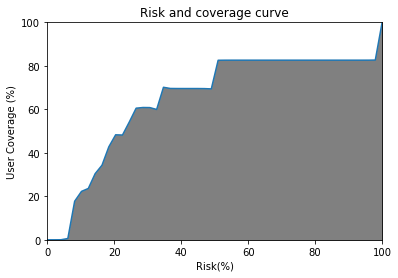

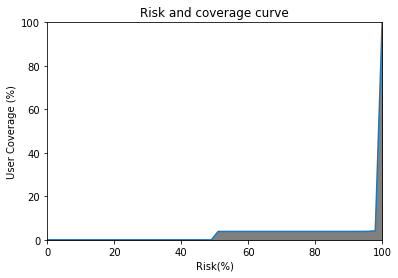

In [38]:
def risk_coverage_curve(result, pas):
    xp = []
    yp = []
    for i in np.arange(0, 1+pas, pas):
        xp.append(i*100)
        yp.append((len(result[result["risk"]<=i])/len(result))*100) # Récupère le nombre de données dont le risk est inférieur ou égal à i. 
    f = interpolate.interp1d(xp, yp,kind="cubic") # Réalise une interpolation des point calculé
    x = np.linspace(0,100)
    y = f(x)
    plt.plot(x, y)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.title("Risk and coverage curve")
    plt.xlabel("Risk(%)")
    plt.ylabel("User Coverage (%)")
    plt.fill_between(x, y,color="gray")
    plt.show()
risk_coverage_curve(result,0.01)
risk_coverage_curve(result_original,0.01)


# Augmentation de la taille des données

In [39]:
trjs_1an = trjs[trjs['time'].between('2019-10-21', '2020-10-21')]
print(len(trjs_1an['uid'].unique()))

62


In [40]:
trjs_1an =TrajDataFrame(trjs_1an, latitude='lat',longitude ='lon',datetime='time', user_id='uid')
ftrjs_1an = filtering.filter(trjs_1an, max_speed_kmh=100.)
ctrjs_1an = compression.compress(ftrjs_1an, spatial_radius_km=0.2)
strjs_1an = detection.stops(ctrjs_1an, stop_radius_factor=0.8,minutes_for_a_stop=10.0, spatial_radius_km=0.2,leaving_time=True)
clust_trjs_1an = clustering.cluster(strjs_1an, cluster_radius_km=0.1, min_samples=1)

In [41]:
len(clust_trjs_1an['cluster'].unique())

8

In [42]:
centroids_1an = clust_trjs_1an.groupby("cluster").mean().reset_index() # Regroupe par cluster fait la moyenne des colonnes restantes, et reset l'index.
centroids_traj_1an = clust_trjs_1an.rename(columns={"lat":"latitude","lng":"longitude"})  # Renomme la colonne lat et lng
centroids_traj_1an = pd.merge(centroids_traj_1an,centroids_1an,left_on="cluster",right_on="cluster") # Fusion de centroids et centroids_traj sur datetime
privacy_trjs_1an = centroids_traj_1an[["datetime","lat","lng","uid"]] # Récupère les colonnes datetime, lat, lng, uid

In [43]:
privacy_trjs_1an.plot_trajectory(max_users = 260)

computing risk: 100%|██████████| 62/62 [00:18<00:00,  3.36it/s]


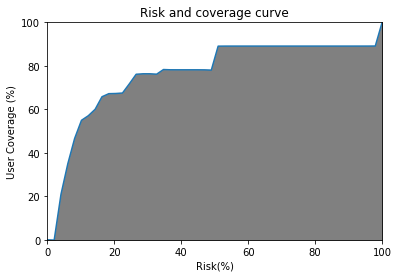

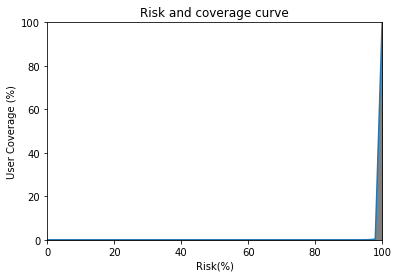

In [44]:
at_1an = attacks.LocationFrequencyAttack(knowledge_length=2,tolerance=0.5)
result_1an = at_1an.assess_risk(privacy_trjs_1an, show_progress=True)
result_1an_original = at_1an.assess_risk(trjs_1an, show_progress=True)
risk_coverage_curve(result_1an,0.01)
risk_coverage_curve(result_1an_original,0.01)